# Project Notebook V: Supervised Learning with Sagemaker XGBoost with Hyperparameter Tuning

David Chen

In [1]:
!pip install sagemaker==1.72.0

     |████████████████████████████████| 297 kB 19.8 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-1.72.0-py2.py3-none-any.whl size=386358 sha256=00bbc301098a33608bcaced2771b082a7514a36c9cd3eebb409d75b158f57db3
  Stored in directory: /home/ec2-user/.cache/pip/wheels/c3/58/70/85faf4437568bfaa4c419937569ba1fe54d44c5db42406bbd7
Successfully built sagemaker
  Attempting uninstall: smdebug-rulesconfig
    Found existing installation: smdebug-rulesconfig 1.0.1
    Uninstalling smdebug-rulesconfig-1.0.1:
      Successfully uninstalled smdebug-rulesconfig-1.0.1
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.41.0
    Uninstalling sagemaker-2.41.0:
      Successfully uninstalled sagemaker-2.41.0


In [2]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
import boto3

In [3]:
## My custom helper functions
from helpers import *

## Step 1. Sagemaker Resources & Processed+FeatureSelected Data Saved in S3

In [4]:
sagemaker_session = sagemaker.Session()
sagemaker_session

In [5]:
role = sagemaker.get_execution_role()
role

'arn:aws:iam::644307290749:role/service-role/AmazonSageMaker-ExecutionRole-20210527T073969'

In [6]:
bucket = sagemaker_session.default_bucket()
bucket

'sagemaker-us-west-1-644307290749'

In [7]:
## Load processed, L1-selected features:
genes = pd.read_csv(get_s3_uri("assets/processed_data/genes_l1_selected.csv", bucket), index_col=0)
genes.shape

(999, 33)

In [8]:
## Load processed patient annotations (with defined class label):
clinical = pd.read_csv(get_s3_uri("assets/processed_data/clinical.csv", bucket))
clinical.index = clinical['Sample ID'].values
clinical.shape

(999, 15)

In [9]:
## Check to see if patient IDs in the 2 DataFrames match
assert all(genes.index == clinical.index)

In [10]:
y = clinical["Label"].astype(int)

## Step 2. Train-val-test split & save for Sagemaker XGBoost

Here, I will split the data into the following sets as CSV files without headers or index (required format for Sagemaker):

* Training Set (for Hyperparameter Tuning)
* Validation Set (Hyperparameter Tuning)
* Test Set (no labels, just features)

To do so, I will:

* Run sklearn's `train_test_split` sequentially, twice
* Use my custom helper function `directS3Save` to export CSV directly to my S3 bucket

In [11]:
from sklearn.model_selection import train_test_split

SIZE_VAL_TEST = 100 #set aside 100 observations or 10% for validation & testing

## Run sklearn helper 1st time to split out the test set:
## The hold-out test set is NEVER used until the very end
Xtrain, Xtest, ytrain, ytest = train_test_split(genes, y, test_size=SIZE_VAL_TEST, random_state=42)

In [12]:
## S3-export the test set FEATURES ONLY -- no concatenation of labels
directS3Save(Xtest, bucket, "assets/tnbc-xgboost/test.csv", False, False)

Run `train_test_split` the second time to split out a validation set for optimization

In [13]:
## 2nd split to get validation set
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain.astype(int), test_size=SIZE_VAL_TEST)

In [14]:
directS3Save(pd.concat([ytrain, Xtrain], axis=1), bucket, "assets/tnbc-xgboost/train.csv", False, False)

In [15]:
directS3Save(pd.concat([yval, Xval], axis=1), bucket, "assets/tnbc-xgboost/validation.csv", False, False)

## Step 3. Train Sagemaker XGBoost with Hyperparameter Tuning

In [16]:
prefix = "assets/tnbc-xgboost"

container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost')
container

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').


'632365934929.dkr.ecr.us-west-1.amazonaws.com/xgboost:1'

### Sagemaker estimator with default hyperparameters

In [17]:
xgb = sagemaker.estimator.Estimator(
    container, 
    role,
    train_instance_count = 1,
    train_instance_type = 'ml.m4.xlarge',
    output_path = 's3://{}/{}/output'.format(bucket, prefix),
    sagemaker_session = sagemaker_session
)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [18]:
## Compute positive class weight
## See doc: docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html

scale_pos_weight = sum(y == 0) / sum(y == 1)
print("Positive class weight = %.2f" % scale_pos_weight)

Positive class weight = 7.69


In [20]:
## Verify this weight is equivalent to what we had for the benchmark SVM model:
## See sklearn doc: scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

class_weights = len(y) / (2 * np.bincount(y))
print("weight_0=%.2f, weight_1=%.2f" % tuple(class_weights))
print("sklearn version of class 1 weight %.2f" % (class_weights[1] / class_weights[0])) #should equal value in the cell above

weight_0=0.57, weight_1=4.34
sklearn version of class 1 weight 7.69


In [21]:
## Set some default XGBoost hyperparameters
xgb.set_hyperparameters(
    max_depth = 5,
    eta = 0.2,
    gamma = 4,
    min_child_weight = 6,
    subsample = 0.8,
    scale_pos_weight = scale_pos_weight,
    objective = 'binary:logistic',
    early_stopping_rounds = 10,
    num_round = 200
)

### Run Hyperparameter Tuning via Random Search

We will maximize Validation-set Area Under the ROC Curve (AUC) with Random Search as the approach for model optimization.

In [22]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

HP_RANGES = {
    'max_depth': IntegerParameter(3, 12),
    'eta': ContinuousParameter(0.05, 0.5),
    'min_child_weight': IntegerParameter(2, 8),
    'subsample': ContinuousParameter(0.5, 0.9),
    'gamma': ContinuousParameter(0, 10)
}

tuner = HyperparameterTuner(
    estimator = xgb,
    objective_metric_name = 'validation:auc', #ATTENTION
    objective_type = 'Maximize', #ATTENTION
    max_jobs = 20,
    max_parallel_jobs = 3, 
    strategy = 'Random', #ATTENTION
    hyperparameter_ranges = HP_RANGES
)

Data paths for Sagemaker need to be handled specially. Further, the syntax of training & validation sets' paths is a little bit different from the test set.

In [23]:
## Required data path / config:
s3_input_train = sagemaker.s3_input(
    s3_data = get_s3_uri(os.path.join(prefix,"train.csv"), bucket), 
    content_type = 'csv'
)

s3_input_val = sagemaker.s3_input(
    s3_data = get_s3_uri(os.path.join(prefix,"validation.csv"), bucket), 
    content_type = 'csv'
)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [24]:
tuner.fit({'train':s3_input_train, 'validation':s3_input_val})

In [25]:
tuner.wait()

........................................................................................................................................................................................................................................................................................................................!


In [26]:
tuner.best_training_job()

'xgboost-210529-0000-011-de06c9f0'

In [27]:
## Get a DataFrame of all models:
df_tune = sagemaker.HyperparameterTuningJobAnalytics(tuner.latest_tuning_job.job_name).dataframe()
df_tune.sort_values(by="FinalObjectiveValue", ascending=False, inplace=True)
df_tune

,eta,gamma,max_depth,min_child_weight,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
9,0.362921,9.778456,10.0,8.0,0.504031,xgboost-210529-0000-011-de06c9f0,Completed,0.978423,2021-05-29 00:14:09+00:00,2021-05-29 00:14:57+00:00,48.0
8,0.228099,2.908494,10.0,4.0,0.740050,xgboost-210529-0000-012-433a0c41,Completed,0.976190,2021-05-29 00:14:44+00:00,2021-05-29 00:15:50+00:00,66.0
7,0.453456,1.255490,9.0,4.0,0.759684,xgboost-210529-0000-013-957df607,Completed,0.975446,2021-05-29 00:17:32+00:00,2021-05-29 00:18:37+00:00,65.0
13,0.366273,1.882522,11.0,6.0,0.688002,xgboost-210529-0000-007-bf521af8,Completed,0.974702,2021-05-29 00:10:16+00:00,2021-05-29 00:11:20+00:00,64.0
19,0.224807,5.205991,7.0,2.0,0.890576,xgboost-210529-0000-001-cef6c149,Completed,0.973214,2021-05-29 00:02:38+00:00,2021-05-29 00:03:54+00:00,76.0
15,0.123025,6.444375,8.0,2.0,0.811051,xgboost-210529-0000-005-754d34bf,Completed,0.973214,2021-05-29 00:06:51+00:00,2021-05-29 00:07:40+00:00,49.0
6,0.291934,9.078776,3.0,7.0,0.633374,xgboost-210529-0000-014-b8de5791,Completed,0.972470,2021-05-29 00:17:33+00:00,2021-05-29 00:18:37+00:00,64.0
16,0.374567,2.653589,11.0,8.0,0.643156,xgboost-210529-0000-004-72a17a50,Completed,0.971726,2021-05-29 00:07:20+00:00,2021-05-29 00:08:16+00:00,56.0
12,0.161827,4.036319,8.0,6.0,0.886041,xgboost-210529-0000-008-8b779e56,Completed,0.970610,2021-05-29 00:10:29+00:00,2021-05-29 00:11:33+00:00,64.0
2,0.417569,8.903582,7.0,7.0,0.504988,xgboost-210529-0000-018-8b031778,Completed,0.968750,2021-05-29 00:21:54+00:00,2021-05-29 00:22:44+00:00,50.0


In [28]:
## Download a copy of the tuning results:
directS3Save(df_tune, bucket, "assets/tnbc-xgboost/xgboost-tuning-results.csv")

## Step 4. Evaluate the Trained Model

### Apply the best model to the hold-out Test Set

In [29]:
xgb_attached = sagemaker.estimator.Estimator.attach(tuner.best_training_job())

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2021-05-29 00:14:57 Starting - Preparing the instances for training
2021-05-29 00:14:57 Downloading - Downloading input data
2021-05-29 00:14:57 Training - Training image download completed. Training in progress.
2021-05-29 00:14:57 Uploading - Uploading generated training model
2021-05-29 00:14:57 Completed - Training job completedArguments: train
[2021-05-29:00:14:44:INFO] Running standalone xgboost training.
[2021-05-29:00:14:44:INFO] Setting up HPO optimized metric to be : auc
[2021-05-29:00:14:44:INFO] File size need to be processed in the node: 0.23mb. Available memory size in the node: 8422.28mb
[2021-05-29:00:14:44:INFO] Determined delimiter of CSV input is ','
[00:14:44] S3DistributionType set as FullyReplicated
[00:14:44] 799x33 matrix with 26367 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-05-29:00:14:44:INFO] Determined delimiter of CSV input is ','
[00:14:44] S3DistributionType set as FullyReplicated
[00:14:44] 100x33 matrix with

In [30]:
transformer = xgb_attached.transformer(instance_count=1, instance_type='ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [31]:
## The syntax for inference is unique from training-validation:
transformer.transform(
    get_s3_uri(os.path.join(prefix,"test.csv"), bucket),
    content_type = 'text/csv', 
    split_type = 'Line'
)

In [32]:
transformer.wait()

.............................
Arguments: serve
[2021-05-29 00:36:49 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2021-05-29 00:36:49 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
Arguments: serve
[2021-05-29 00:36:49 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2021-05-29 00:36:49 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2021-05-29 00:36:49 +0000] [1] [INFO] Using worker: gevent
[2021-05-29 00:36:49 +0000] [20] [INFO] Booting worker with pid: 20
[2021-05-29 00:36:49 +0000] [21] [INFO] Booting worker with pid: 21
[2021-05-29 00:36:49 +0000] [22] [INFO] Booting worker with pid: 22
[2021-05-29 00:36:49 +0000] [23] [INFO] Booting worker with pid: 23
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.co

In [33]:
## Magick-copy XGBoost inference output to specified directory accessible by Notebook
data_dir = './'

In [34]:
!aws s3 cp --recursive $transformer.output_path $data_dir

download: s3://sagemaker-us-west-1-644307290749/xgboost-210529-0000-011-de06c9f0-2021-05-29-00-32-04-449/test.csv.out to ./test.csv.out


### Show evaluation metrics on the hold-out Test Set

In [35]:
yTestScore = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

In [36]:
yTestPred = (yTestScore > 0.5).astype(int)

In [37]:
from sklearn import metrics

## Table of classification metrics
print(metrics.classification_report(ytest, yTestPred))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95        89
           1       0.56      0.82      0.67        11

    accuracy                           0.91       100
   macro avg       0.77      0.87      0.81       100
weighted avg       0.93      0.91      0.92       100



In [38]:
## Confusion matrix
metrics.confusion_matrix(ytest, yTestPred)

array([[82,  7],
       [ 2,  9]])

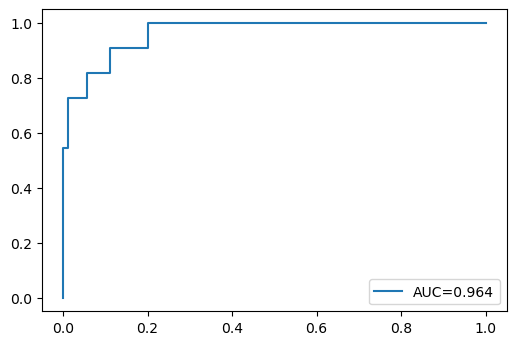

In [39]:
plot_roc(ytest, yTestScore)